# Machine Learning NLP notebook for idenitfying ML methods papers in life science jorunal 
## 1. 

[('title', 'NN'), ('classification', 'NN'), ('pallidal', 'JJ'), ('oscillation', 'NN'), ('increasing', 'VBG'), ('parkinsonian', 'JJ'), ('severity', 'NN'), ('abstract', 'NN'), ('firing', 'VBG'), ('pattern', 'JJ'), ('neuron', 'NN'), ('basal', 'NN'), ('ganglion', 'NN'), ('known', 'VBN'), ('become', 'JJ'), ('oscillatory', 'JJ'), ('synchronized', 'VBN'), ('healthy', 'JJ'), ('parkinsonian', 'JJ'), ('condition', 'NN'), ('similar', 'JJ'), ('change', 'NN'), ('observed', 'VBD'), ('local', 'JJ'), ('field', 'NN'), ('potential', 'NN'), ('lfps', 'NN'), ('study', 'NN'), ('used', 'VBD'), ('unbiased', 'JJ'), ('machine', 'NN'), ('learning', 'VBG'), ('approach', 'NN'), ('investigate', 'JJ'), ('utility', 'NN'), ('pallidal', 'NN'), ('lfps', 'NN'), ('discriminating', 'VBG'), ('stage', 'NN'), ('progressive', 'JJ'), ('parkinsonian', 'JJ'), ('model', 'NN'), ('feature', 'NN'), ('selection', 'NN'), ('algorithm', 'NN'), ('used', 'VBN'), ('identify', 'VB'), ('subset', 'JJ'), ('lfp', 'JJ'), ('feature', 'NN'), ('prov

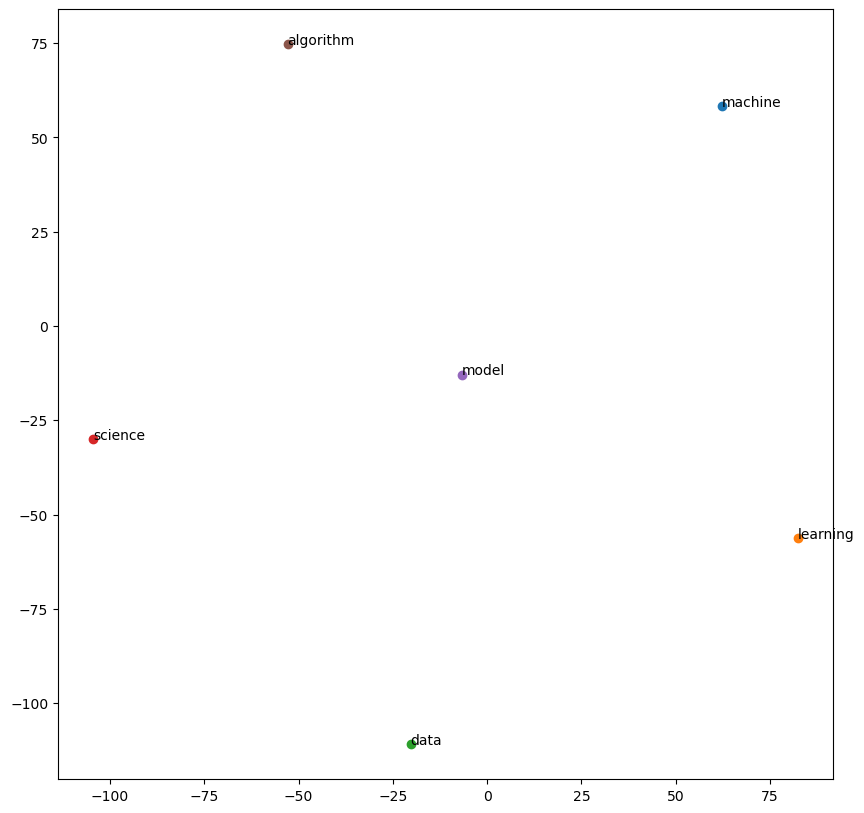

In [ ]:
# 1. Preprocess DOME data & get insights from the literature data for use with developing ML lit triage model 

# 1A. DOME abstract and title

# 1. Import Necessary Libraries 
# Ensures that all required NLP libraries (NLTK, Scikit-learn, Gensim, etc.) are available.  
# import spacy # depedncy issues avoided for now 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.sparse
import joblib

import os
from os import listdir
from os.path import isfile, join

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
#nltk.download('all')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')

import gensim
from gensim.models import Word2Vec

import sklearn
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 2. Load Data
# Load the DOME abstract and title data text files 
# Read in names of PMC files in title and abstract folder + put into variable 
title_abstract_names = os.listdir('./DOME_Registry_PMC_Title_Abstract')
# Read in the text from each file and put into a new list var for usage
title_abstract_names_list = []
for file in title_abstract_names:
    with open('./DOME_Registry_PMC_Title_Abstract/' + file, 'r') as f:
        title_abstract_names_list.append(f.read())
        
# 2. Text Cleaning & Normalization  
# 2.1 Lowercasing function and implementation to enable case-insensitive matching.  
def lowercasing(text):
    return text.lower()

clean1_title_abstract = []
for title_abstract in title_abstract_names_list:
    clean1_title_abstract.append(lowercasing(title_abstract))

# print(lower_title_abstract[4])

# 2.2 Remove Special Characters & Numbers function and implementation --> do not do for full text
def remove_special_chars_numbers(text):
    # Remove numbers and special characters, keeping only letters and spaces using regex replace
    cleaned_text = re.sub(r'[^A-Za-z\s]', ' ', text)
    return cleaned_text

clean2_title_abstract = []
for title_abstract in clean1_title_abstract:
    clean2_title_abstract.append(remove_special_chars_numbers(title_abstract))
    
#print(clean2_title_abstract[0])

# 2.3 Remove any double white spaces
def remove_extra_whitespace(text):
    return ' '.join(text.split())

clean3_title_abstract = []
for title_abstract in clean2_title_abstract:
    clean3_title_abstract.append(remove_extra_whitespace(title_abstract))

#print(clean3_title_abstract[0])

# 3. Tokenization & Basic Cleaning  
# 3.1 Tokenization - Splits text into individual words (we can also try subwords or sentence level for full text). 
# Tokenizer choice - to be explained
clean4_title_abstract = []

for title_abstract in clean3_title_abstract:
    clean4_title_abstract.append(word_tokenize(title_abstract))

#print(clean4_title_abstract[180])

# 3.2 Ensure proper word separation - ignore for the moment, address if tokenisation issues 

# 3.3 Removing Stopwords - Eliminates commonly occurring but uninformative words.  
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return [word for word in text if word not in stop_words]

clean5_title_abstract = []
for title_abstract in clean4_title_abstract:
    clean5_title_abstract.append(remove_stopwords(title_abstract))

# print(clean5_title_abstract[180])

# 4. Lemmatization (or Stemming - where would be preferred)  
# Lemmatization → Converts words to their root form.  
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

clean6_title_abstract = []
for title_abstract in clean5_title_abstract:
    clean6_title_abstract.append(lemmatize(title_abstract))

#print(clean5_title_abstract[180])
#print(clean6_title_abstract[180])

# 5. Feature Extraction  
# 5.1 Part-of-Speech (POS) Tagging & Counts  
def pos_tagging(text):
    nltk.pos_tag(text)
    return pos_tag(text)

pos_tags = []
for title_abstract in clean6_title_abstract:
    pos_tags.append(pos_tagging(title_abstract))

print(pos_tags[180])

# 5.2 Named Entity Recognition (NER)  


# 5.3 Term Frequency - Inverse Document Frequency - (TF-IDF)  
# To try on doc basis and also on full corpus basis

# 5.3.1 Term frequency → Measures how frequently a term occurs in a document.
def compute_term_frequency(documents):
    vectorizer = CountVectorizer()
    tf_matrix = vectorizer.fit_transform(documents)
    return tf_matrix, vectorizer.get_feature_names_out()

# 5.3.2 IDF → Measures how important a term is within a corpus.
def compute_inverse_document_frequency(tf_matrix):
    transformer = TfidfTransformer(norm=None, use_idf=True)
    transformer.fit(tf_matrix)
    idf = transformer.idf_
    return idf

# 5.3.3 TF-IDF → Combines the above two metrics to determine the importance of a term in a document relative to a corpus.
def compute_tf_idf(documents):
    vectorizer = TfidfVectorizer()
    tf_idf_matrix = vectorizer.fit_transform(documents)
    return tf_idf_matrix, vectorizer.get_feature_names_out()

# Example usage:
documents = [" ".join(doc) for doc in clean6_title_abstract]
tf_matrix, terms = compute_term_frequency(documents)
idf = compute_inverse_document_frequency(tf_matrix)
tf_idf_matrix, tf_idf_terms = compute_tf_idf(documents)

print("TF Matrix Shape:", tf_matrix.shape)
print("IDF Shape:", idf.shape)
print("TF-IDF Matrix Shape:", tf_idf_matrix.shape)

# Save the matrices and terms
output_dir = './DOME_Registry_PMC_Title_Abstract_Analysis'
os.makedirs(output_dir, exist_ok=True)

# Convert sparse matrix to dense format for saving as CSV
tf_matrix_dense = tf_matrix.toarray()
tf_idf_matrix_dense = tf_idf_matrix.toarray()

# Save as CSV
pd.DataFrame(tf_matrix_dense, columns=terms).to_csv(os.path.join(output_dir, 'Title_Abstract_tf_matrix.csv'), index=False)
pd.DataFrame({'term': terms, 'idf': idf}).to_csv(os.path.join(output_dir, 'Title_Abstract_idf.csv'), index=False)
pd.DataFrame(tf_idf_matrix_dense, columns=tf_idf_terms).to_csv(os.path.join(output_dir, 'Title_Abstract_tf_idf_matrix.csv'), index=False)

# 5.4 Bag of Words (BoW)
def compute_bag_of_words(documents):
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(documents)
    return bow_matrix, vectorizer.get_feature_names_out()

# BOW usage:
bow_matrix, bow_terms = compute_bag_of_words(documents)
print("BoW Matrix Shape:", bow_matrix.shape)

# Save BoW matrix as CSV
bow_matrix_dense = bow_matrix.toarray()
pd.DataFrame(bow_matrix_dense, columns=bow_terms).to_csv(os.path.join(output_dir, 'bow_matrix.csv'), index=False)

# 5.4 Word Embeddings (Word2Vec, GloVe, BERT, etc.)
def compute_word2vec_gensim(documents):
    model = Word2Vec(sentences=documents, vector_size=100, window=5, min_count=1, workers=4)
    return model

# Example usage:
word2vec_model = compute_word2vec_gensim(clean6_title_abstract)
print("Word2Vec Model Vocabulary Size:", len(word2vec_model.wv))

# Display the vector for a sample word
sample_word = 'machine'
if sample_word in word2vec_model.wv:
    print(f"Vector for '{sample_word}':", word2vec_model.wv[sample_word])
else:
    print(f"'{sample_word}' not in vocabulary")

# Visualize Word2Vec word clusters
def visualize_word_clusters(model, words):
    word_vectors = np.array([model.wv[word] for word in words if word in model.wv])
    tsne = TSNE(n_components=2, random_state=0, perplexity=5)  # Set perplexity to a value less than the number of words
    word_vectors_2d = tsne.fit_transform(word_vectors)
    
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        if word in model.wv:
            plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
            plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))
    plt.show()

# Example usage:
sample_words = ['machine', 'learning', 'data', 'science', 'model', 'algorithm']
visualize_word_clusters(word2vec_model, sample_words)

# 6. Vectorization (Final Step)
# #n-Grams – Captures sequences of words. Example: Bi-gram: "machine learning" → (["machine", "learning"]).  
# ✔ TF-IDF OR Embeddings (Step 1.9) → Converts text into a numerical representation suitable for ML models.  
# (Vectorization is technically part of feature extraction, so this step can be merged with 1.6 if preferred.)

# Try title only and then abstarct only


# 1B. DOME full text 


In [ ]:
#To do
# topic modelling
# analyse the oooutputs
# use outputs for identifying more relavnt papers 



In [ ]:
# Identify using ml ontology and others rleevant ML words not within - eg: model types etc


In [ ]:
# 2. Determine if wider corpus of ML papers needed - automatically find some papers and then also preprocess
# could dtermine using text word mining
#random papers form lit suggest or negatiev search of terms - eg noo model/ml etc 
#  

In [ ]:
# 3. Preprocess all ML papers

In [ ]:
# 4. Download all papers mentioning machine learning and AI from EPMC 

In [ ]:
# 5. Deploy ML model to predict if a paper is about ML or not

In [ ]:
# 6. Analyse top papers and journals insights from the literature data